# Introduction to sentiment analysis with NLI

In this notebook, you will implement a sentiment scoring pipeline using a Natural Language Inference (NLI) model.
You will analyze whether news headlines about S&P 500 companies have positive or negative sentiment and explore how this sentiment correlates with market returns.


## Install and Import librairies
Install necessary packages and import the required libraries for:
- Loading data
- Using transformer models
- Plotting and visualizing results
- Downloading financial data

In [ ]:
%pip install hf_xet
%pip install yfinance

In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from scipy.special import softmax
from google.colab import drive

import torch
import math
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd

## Load news data
Load two datasets:
- `df_news.csv`: contains headlines and summaries
- `df_metadata.csv`: contains ticker symbols and company sector info

We drop duplicate summaries to avoid redundant sentiment scoring.

In [3]:
drive.mount('/content/drive')
news_file_path = '/content/drive/MyDrive/Colab Notebooks/MNA/Fintech/Week 3/df_news.csv'

Mounted at /content/drive


In [5]:
df_news = pd.read_csv(news_file_path)
df_news.drop_duplicates('SUMMARY', inplace=True)
display(df_news)

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...
...,...,...,...,...,...,...
4866,ZTS,2 Dividend Stocks to Buy With $500 and Hold Fo...,Zoetis is a leading animal health company with...,2025-05-23 10:30:00+00:00,Motley Fool,https://www.fool.com/investing/2025/05/23/2-di...
4867,ZTS,Zoetis (NYSE:ZTS) Declares US$0.50 Dividend Pe...,Zoetis (NYSE:ZTS) recently affirmed a dividend...,2025-05-22 17:49:43+00:00,Simply Wall St.,https://finance.yahoo.com/news/zoetis-nyse-zts...
4868,ZTS,Jim Cramer on Zoetis (ZTS): “It Does Seem to B...,We recently published a list of Jim Cramer Tal...,2025-05-21 18:14:38+00:00,Insider Monkey,https://finance.yahoo.com/news/jim-cramer-zoet...
4869,ZTS,Zoetis (ZTS) Upgraded to Buy: Here's Why,Zoetis (ZTS) might move higher on growing opti...,2025-05-21 16:00:08+00:00,Zacks,https://finance.yahoo.com/news/zoetis-zts-upgr...


In [6]:
df_meta = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/MNA/Fintech/Week 5/df_metadata-1.csv')
display(df_meta)

,TICKER,COMPANY_NAME,SECTOR,INDUSTRY
0,MMM,3M Company,Industrials,Conglomerates
1,AOS,A. O. Smith Corporation,Industrials,Specialty Industrial Machinery
2,ABT,Abbott Laboratories,Healthcare,Medical Devices
3,ABBV,AbbVie Inc.,Healthcare,Drug Manufacturers - General
4,ACN,Accenture plc,Technology,Information Technology Services
...,...,...,...,...
485,XEL,Xcel Energy Inc.,Utilities,Utilities - Regulated Electric
486,XYL,Xylem Inc.,Industrials,Specialty Industrial Machinery
487,YUM,"Yum! Brands, Inc.",Consumer Cyclical,Restaurants
488,ZBH,"Zimmer Biomet Holdings, Inc.",Healthcare,Medical Devices


## Sentiment Analysis with NLI

In this section, you will apply a CrossEncoder NLI model (`cross-encoder/nli-deberta-v3-base`) to estimate sentiment from news headlines.

👉 **Instructions**:

1. Use a CrossEncoder NLI model to compute how much a news headline implies a **positive** or **negative** sentiment.
2. For each news title, compute the probability of it being **positive** and **negative**, and store them in `POSITIVE_PROB` and `NEGATIVE_PROB`.
3. Derive a final sentiment score by subtracting: `SENTIMENT = POSITIVE_PROB - NEGATIVE_PROB`.

✅ This score will serve as your sentiment signal, ranging from negative to positive.

> ℹ️ You are free to decide how to structure the input pairs and how to apply the model.


### Instantiate NLI model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cross-encoder/nli-deberta-v3-base")
cross_encoder = AutoModelForSequenceClassification.from_pretrained("cross-encoder/nli-deberta-v3-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cross_encoder.to(device)

In [8]:
premise = "This news is positive"
hypotheses = df_news["TITLE"].tolist()

In [9]:
positive_probs = []
negative_probs = []

for hypothesis in hypotheses:
    inputs = tokenizer(premise, hypothesis, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        logits = cross_encoder(**inputs).logits
        probs = softmax(logits.cpu().numpy()[0])

    positive_prob = probs[2]  # entailment
    negative_prob = probs[0]  # contradiction

    positive_probs.append(positive_prob)
    negative_probs.append(negative_prob)

In [10]:
df_news["POSITIVE_PROB"] = positive_probs
df_news["NEGATIVE_PROB"] = negative_probs
df_news["SENTIMENT"] = df_news["POSITIVE_PROB"] - df_news["NEGATIVE_PROB"]

In [11]:
df_news.head()

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...,0.977126,0.021884,0.955241
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...,0.965395,0.033239,0.932156
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...,0.999587,0.000076,0.999511
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...,0.998686,0.000641,0.998044
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...,0.001308,0.998623,-0.997315


## Compare Sentiment with Returns

In this section, you'll explore how daily news sentiment aligns with market behavior.

👉 **Instructions**:

1. Group the news data by **publication date** and compute the **average sentiment per day**.
2. Download **daily stock prices** for the relevant tickers using `yfinance`.
3. Compute **daily returns** and use their average as a proxy for the market (e.g., S\&P 500).
4. Visualize both **daily sentiment** and **daily returns** over time using line plots.
5. Create a **dual y-axis chart** to compare trends more effectively.

✅ This section helps you assess whether changes in sentiment coincide with market movements.

> ℹ️ Focus on trend relationships, not just visual similarity—this is an opportunity to start thinking about predictive signals.

### Make sure the publication date is datetime type

In [12]:
df_news['PUBLICATION_DATE'] = pd.to_datetime(df_news['PUBLICATION_DATE'])

In [13]:
df_news.head()

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...,0.977126,0.021884,0.955241
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...,0.965395,0.033239,0.932156
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...,0.999587,0.000076,0.999511
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...,0.998686,0.000641,0.998044
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...,0.001308,0.998623,-0.997315


### Group the news by publication date and get the average sentiment score per day

In [14]:
daily_sentiment = df_news.groupby(df_news['PUBLICATION_DATE'].dt.date)['SENTIMENT'].mean()

In [15]:
daily_sentiment.head()

,SENTIMENT
PUBLICATION_DATE,
2024-07-12,0.993779
2024-07-22,0.995335
2024-08-19,0.980083
2024-09-13,0.999005
2024-10-26,0.998123


In [16]:
len(daily_sentiment)

118

### Get a list of tickers

In [17]:
tickers = df_news['TICKER'].unique().tolist()

### Download the daily stock prices from yfinance

In [18]:
price_data = yf.download(tickers, start=daily_sentiment.index.min().strftime('%Y-%m-%d'), end=daily_sentiment.index.max().strftime('%Y-%m-%d'))

/tmp/ipython-input-2527237125.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_data = yf.download(tickers, start=daily_sentiment.index.min().strftime('%Y-%m-%d'), end=daily_sentiment.index.max().strftime('%Y-%m-%d'))
[*********************100%***********************]  487 of 487 completed


In [19]:
price_data

Price            Close                                                  \
Ticker               A        AAPL        ABBV        ABNB         ABT   
Date                                                                     
2024-07-12  131.220551  229.206711  162.903961  146.779999  101.715218   
2024-07-15  130.009857  233.044403  162.228149  147.220001  101.018578   
2024-07-16  135.021301  233.461990  163.357727  151.259995  100.783112   
2024-07-17  132.480835  227.556351  169.218170  148.000000  102.706161   
2024-07-18  130.962540  222.883499  165.230774  146.880005   98.183075   
...                ...         ...         ...         ...         ...   
2025-05-23  108.301918  195.048645  181.690720  126.720001  130.713272   
2025-05-27  111.026184  199.983047  184.129669  129.399994  132.345932   
2025-05-28  110.646980  200.192795  181.522171  128.669998  131.430054   
2025-05-29  113.041939  199.723328  184.030518  128.360001  132.256348   
2025-05-30  111.684792  200.622314  184.516327  129.000000  132.983078   

Price                                                                 ...  \
Ticker           ACGL         ACN        ADBE         ADI        ADM  ...   
Date                                                                  ...   
2024-07-12  91.761711  305.015961  559.049988  234.530670  61.806522  ...   
2024-07-15  92.389305  312.125092  565.710022  233.704834  60.960388  ...   
2024-07-16  92.341759  319.126251  566.539978  239.220108  62.075748  ...   
2024-07-17  93.064438  319.715454  563.090027  231.630478  63.191116  ...   
2024-07-18  93.416267  322.170227  556.849976  234.953400  62.296898  ...   
...               ...         ...         ...         ...        ...  ...   
2025-05-23  92.070000  308.039368  407.690002  209.516083  47.939999  ...   
2025-05-27  94.620003  313.860260  413.100006  215.906982  48.630001  ...   
2025-05-28  92.980003  314.417480  412.230011  214.642731  48.349998  ...   
2025-05-29  94.199997  316.148834  413.359985  214.772156  48.369999  ...   
2025-05-30  95.040001  315.243378  415.089996  213.010162  48.270000  ...   

Price       Volume                                                         \
Ticker         WST     WTW        WY     WYNN      XEL       XOM      XYL   
Date                                                                        
2024-07-12  631600  313000   5489200  1776200  2353800  11684900   763100   
2024-07-15  443700  360100   3685500  1868800  2219600  13032500  1190800   
2024-07-16  366700  326700   2884900  2010500  2377700  13614100  1212500   
2024-07-17  291500  346100   3253100  2042200  3242100  13602800  1214500   
2024-07-18  533800  345200   3436800  2317600  3023900  13033600   962400   
...            ...     ...       ...      ...      ...       ...      ...   
2025-05-23  606100  372300   3343400  1335800  3077400  12061600  1282300   
2025-05-27  559900  608500   4214500  1813400  2578600  13043600  1151100   
2025-05-28  424200  603800   3801800  1405600  2425600  14292400   985500   
2025-05-29  582600  412400   3538200  2208400  2024800  13825300   887600   
2025-05-30  879600  809700  11663800  6827900  3985800  28645800  2624100   

Price                                  
Ticker          YUM      ZBH      ZTS  
Date                                   
2024-07-12  2338800  1177400  1672800  
2024-07-15  2157100  1822600  2216500  
2024-07-16  2381300  1211700  1939900  
2024-07-17  1753800  2237000  2190800  
2024-07-18  1714700  2278200  2171100  
...             ...      ...      ...  
2025-05-23  1062900  3141100  2732200  
2025-05-27  2396800  3885600  2323100  
2025-05-28  1537000  1475200  1723700  
2025-05-29  1841900  1650500  2450400  
2025-05-30  3184400  3505200  5467800  

[222 rows x 2435 columns]

### Get the close price from the previous data

In [20]:
close_prices = price_data['Close']

In [21]:
close_prices.head()

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WST,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-12,131.220551,229.206711,162.903961,146.779999,101.715218,91.761711,305.015961,559.049988,234.530670,61.806522,...,321.768036,261.168243,28.475710,84.866692,52.492413,108.444321,136.805145,128.784729,107.694809,176.468246
2024-07-15,130.009857,233.044403,162.228149,147.220001,101.018578,92.389305,312.125092,565.710022,233.704834,60.960388,...,318.908813,260.298370,28.242302,83.650490,51.476990,110.301659,135.698227,125.430496,105.554581,175.423462
2024-07-16,135.021301,233.461990,163.357727,151.259995,100.783112,92.341759,319.126251,566.539978,239.220108,62.075748,...,327.875000,261.277008,28.913347,84.985336,52.153938,111.096298,139.612000,126.440674,106.476067,180.282669
2024-07-17,132.480835,227.556351,169.218170,148.000000,102.706161,93.064438,319.715454,563.090027,231.630478,63.191116,...,325.812805,264.390717,29.652472,83.966911,53.498165,112.628143,137.378372,126.842804,110.033195,179.435013
2024-07-18,130.962540,222.883499,165.230774,146.880005,98.183075,93.416267,322.170227,556.849976,234.953400,62.296898,...,315.152924,263.570312,29.477417,82.543068,53.943016,113.738731,136.429565,125.842415,110.370079,177.075729


### Calculate daily returns with pct_change

In [22]:
daily_returns = close_prices.pct_change().mean(axis=1)

In [23]:
daily_returns.head()

,0
Date,
2024-07-12,NaN
2024-07-15,0.001211
2024-07-16,0.016936
2024-07-17,-0.004467
2024-07-18,-0.008651


### Line chart to compare daily sentiment vs market returns

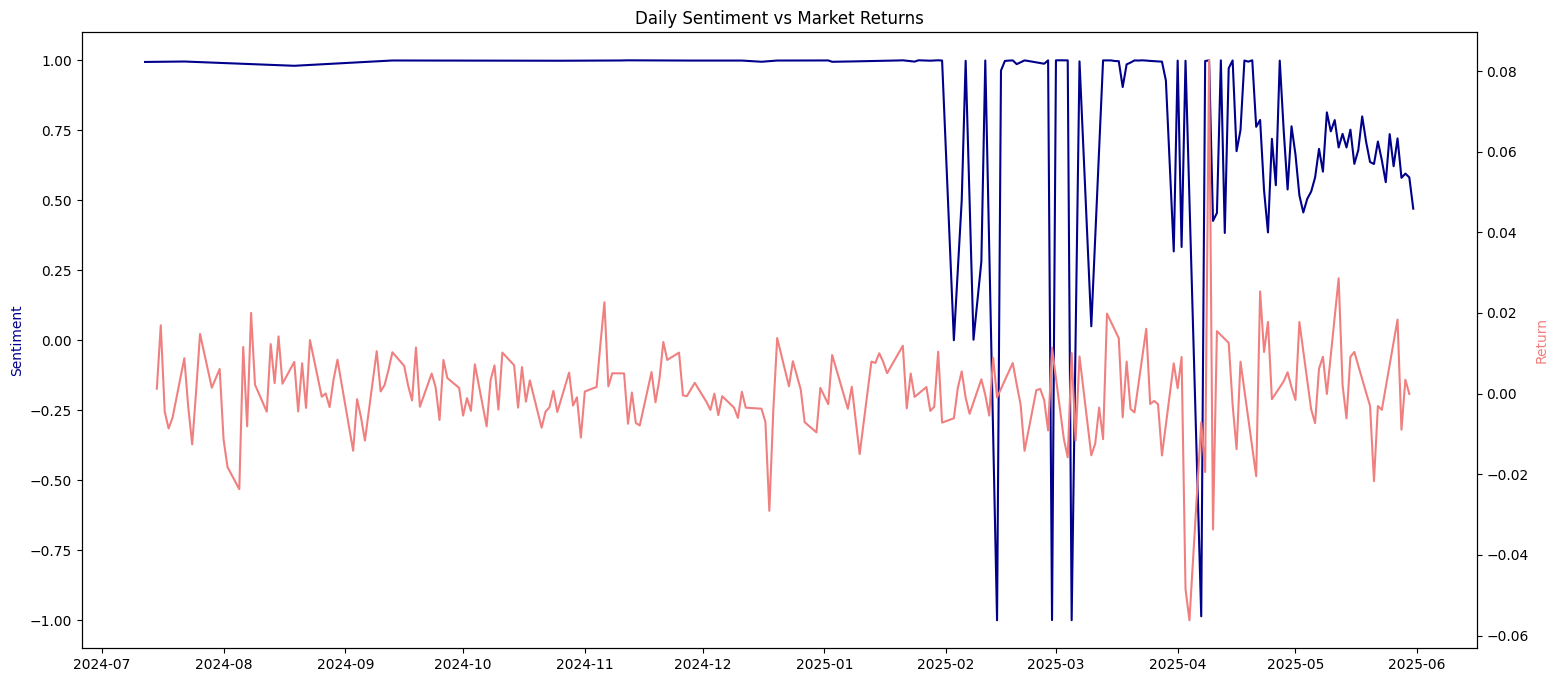

In [24]:
fig, ax1 = plt.subplots(figsize=(18, 8))
ax1.plot(daily_sentiment.index, daily_sentiment.values, color='darkblue', label='Average Daily Sentiment')
ax1.set_ylabel('Sentiment', color='darkblue')
ax2 = ax1.twinx()
ax2.plot(daily_returns.index, daily_returns.values, color='lightcoral', label='Average Daily Return')
ax2.set_ylabel('Return', color='lightcoral')
plt.title('Daily Sentiment vs Market Returns')
plt.show()

## Compare Daily Portfolio Value Against Daily Average Sentiment

In this section, you will simulate a simple market portfolio and explore how its performance aligns with daily sentiment scores.

👉 **Instructions**:

1. Simulate a **market portfolio** by computing the cumulative return of the average daily return across all tickers.
2. Start the portfolio with an **initial value of 1.0** and track its value over time.
3. Plot the **daily average sentiment** and the **portfolio value** using a dual-axis line chart.

✅ This visualization lets you explore whether market sentiment leads or lags behind portfolio movements.

> ℹ️ Think about how this setup could inform a basic trading strategy—or whether sentiment could serve as a timing signal.


In [31]:
portfolio_value = (1 + daily_returns.fillna(0)).cumprod()

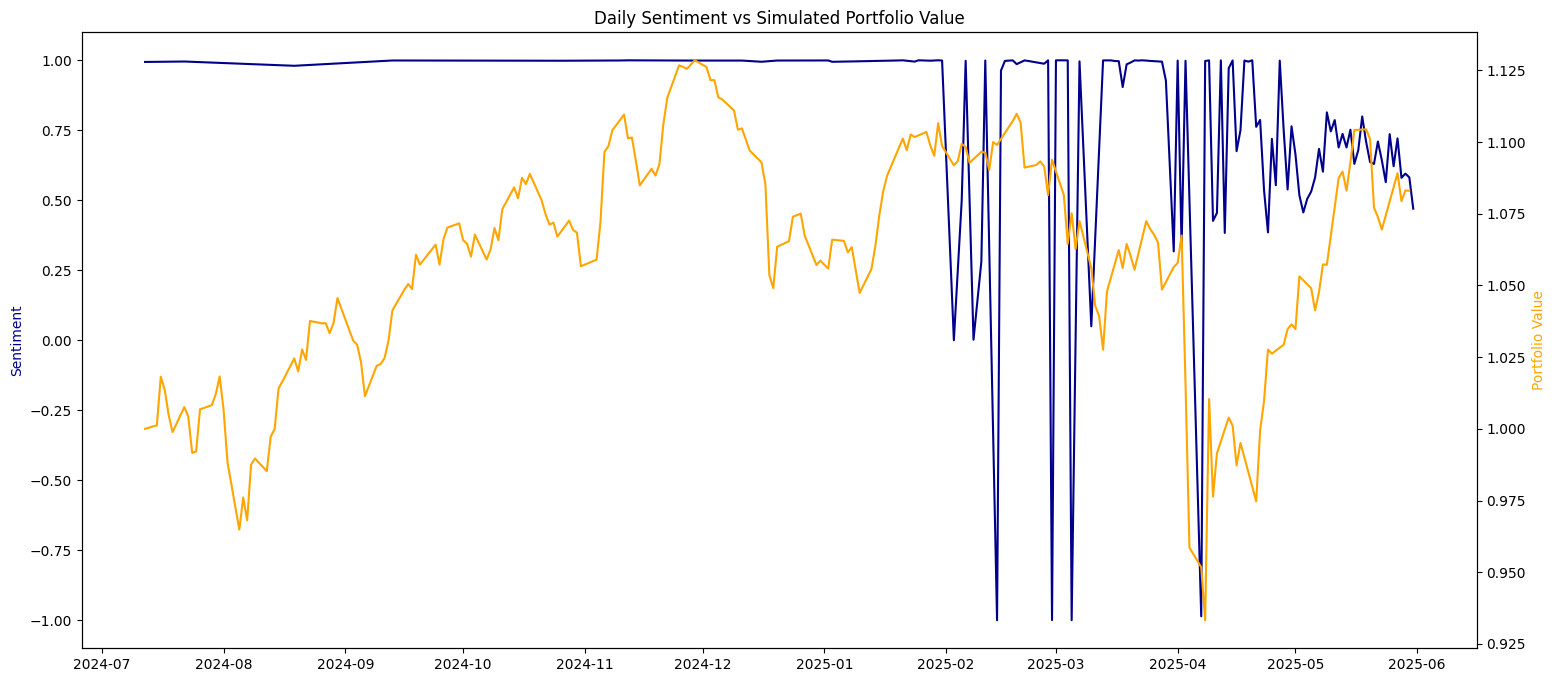

In [32]:
fig, ax1 = plt.subplots(figsize=(18, 8))
ax1.plot(daily_sentiment.index, daily_sentiment.values, color='darkblue', label='Average Daily Sentiment')
ax1.set_ylabel('Sentiment', color='darkblue')
ax2 = ax1.twinx()
ax2.plot(portfolio_value.index, portfolio_value.values, color='orange', label='Portfolio Value')
ax2.set_ylabel('Portfolio Value', color='orange')
plt.title('Daily Sentiment vs Simulated Portfolio Value')
plt.show()

## Compute Sector-Level Sentiment and Returns

In this section, you’ll analyze how sector-level news sentiment compares to market performance for May. You’ll also measure whether sentiment correlates with returns.

👉 **Instructions**:

1. Group companies by **sector** using the metadata.
2. For each sector:

   * Compute **monthly average sentiment** (Feb to May).
   * (Optional) Count the number of headlines per month.
3. Compute **monthly stock returns** from price data and extract **May returns**.
4. Build a comparison table with:

   * `SECTOR`
   * `SENTIMENT` (May sentiment)
   * `RETURN` (May return)
5. Compute and print the **correlation** between May sentiment and May returns.

✅ This step helps evaluate whether optimistic news coverage for a sector is associated with better performance.

> 💡 Once your analysis is complete, consider:
>
> * Which sectors *looked* good in the news but didn’t perform?
> * Which sectors performed well despite neutral/negative sentiment?
> * Would you invest based on sentiment alone? Why or why not?



### Extract the month of each publication date and create a new column

In [33]:
df_news['MONTH'] = df_news['PUBLICATION_DATE'].dt.to_period('M')

/tmp/ipython-input-1393642711.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_news['MONTH'] = df_news['PUBLICATION_DATE'].dt.to_period('M')


In [35]:
df_news.head()

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT,MONTH,SECTOR
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...,0.977126,0.021884,0.955241,2025-05,Industrials
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...,0.965395,0.033239,0.932156,2025-05,Industrials
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...,0.999587,0.000076,0.999511,2025-05,Industrials
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...,0.998686,0.000641,0.998044,2025-05,Industrials
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...,0.001308,0.998623,-0.997315,2025-05,Industrials


### Add a new columns with the sector from the metadata

In [48]:
df_news = df_news.merge(df_meta[['TICKER', 'SECTOR']], on='TICKER', how='left')

In [49]:
df_news.head()

,TICKER,TITLE,SUMMARY,PUBLICATION_DATE,PROVIDER,URL,POSITIVE_PROB,NEGATIVE_PROB,SENTIMENT,MONTH,SECTOR
0,MMM,2 Dow Jones Stocks with Promising Prospects an...,The Dow Jones (^DJI) is made up of 30 of the m...,2025-05-29 04:33:58+00:00,StockStory,https://finance.yahoo.com/news/2-dow-jones-sto...,0.977126,0.021884,0.955241,2025-05,Industrials
1,MMM,3 S&P 500 Stocks Skating on Thin Ice,The S&P 500 (^GSPC) is often seen as a benchma...,2025-05-27 04:34:42+00:00,StockStory,https://finance.yahoo.com/news/3-p-500-stocks-...,0.965395,0.033239,0.932156,2025-05,Industrials
2,MMM,3M Rises 15.8% YTD: Should You Buy the Stock N...,"MMM is making strides in the aerospace, indust...",2025-05-22 14:08:00+00:00,Zacks,https://finance.yahoo.com/news/3m-rises-15-8-y...,0.999587,0.000076,0.999511,2025-05,Industrials
3,MMM,Q1 Earnings Roundup: 3M (NYSE:MMM) And The Res...,Quarterly earnings results are a good time to ...,2025-05-22 03:31:21+00:00,StockStory,https://finance.yahoo.com/news/q1-earnings-rou...,0.998686,0.000641,0.998044,2025-05,Industrials
4,MMM,3 Cash-Producing Stocks with Questionable Fund...,While strong cash flow is a key indicator of s...,2025-05-19 04:41:32+00:00,StockStory,https://finance.yahoo.com/news/3-cash-producin...,0.001308,0.998623,-0.997315,2025-05,Industrials


### Get the sentiment score per month by sector

In [50]:
monthly_sector_sentiment = df_news.groupby(['SECTOR', 'MONTH'])['SENTIMENT'].mean().unstack()

In [52]:
monthly_sector_sentiment

MONTH,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05
SECTOR,,,,,,,,,,,
Basic Materials,NaN,NaN,NaN,NaN,NaN,NaN,0.999279,-0.995474,0.999386,0.290322,0.692059
Communication Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998504,0.199210,0.664479
Consumer Cyclical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.978338,0.036317,0.435469,0.568914
Consumer Defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.999929,0.005502,0.592920
Energy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.998509,0.832159,0.648644
Financial Services,NaN,NaN,NaN,NaN,0.998732,NaN,NaN,0.405788,0.989550,0.722734,0.635905
Healthcare,NaN,NaN,NaN,NaN,0.999293,0.994462,0.997054,0.987535,NaN,0.978746,0.617561
Industrials,NaN,NaN,NaN,NaN,NaN,NaN,0.999328,0.666011,0.999332,0.475154,0.621241
Real Estate,0.994557,0.980083,0.999005,0.998123,NaN,0.998731,0.997890,0.998200,0.979364,0.817701,0.797870


### Count number of headlines per month

In [53]:
monthly_sector_counts = df_news.groupby(['SECTOR', 'MONTH'])['TITLE'].count().unstack()

In [54]:
monthly_sector_counts

MONTH,2024-07,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05
SECTOR,,,,,,,,,,,
Basic Materials,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,4.0,10.0,135.0
Communication Services,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,5.0,144.0
Consumer Cyclical,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,18.0,409.0
Consumer Defensive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,10.0,270.0
Energy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,12.0,172.0
Financial Services,NaN,NaN,NaN,NaN,1.0,NaN,NaN,7.0,9.0,111.0,453.0
Healthcare,NaN,NaN,NaN,NaN,2.0,1.0,2.0,2.0,NaN,5.0,446.0
Industrials,NaN,NaN,NaN,NaN,NaN,NaN,1.0,6.0,2.0,19.0,539.0
Real Estate,2.0,1.0,1.0,1.0,NaN,1.0,3.0,2.0,6.0,59.0,188.0


### Get monthly prices

In [55]:
monthly_prices = close_prices.resample('M').last()

/tmp/ipython-input-989500574.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = close_prices.resample('M').last()


In [56]:
monthly_prices

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WST,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-31,140.320526,220.795654,178.921158,139.559998,103.942398,91.077057,324.644684,551.650024,227.471924,59.623875,...,305.224915,279.030182,30.887587,81.890480,56.360680,113.537666,131.942551,130.275497,110.330444,177.875961
2024-08-31,141.828949,227.939163,189.531693,117.309998,111.134186,107.537109,335.769928,574.409973,230.873489,59.144268,...,312.661896,288.747040,29.848261,76.267067,59.213528,113.824432,136.286758,132.985535,114.402817,181.284515
2024-09-30,147.346497,231.920639,190.661270,126.809998,111.860229,106.386528,347.091553,517.780029,227.172318,57.932095,...,299.233490,292.016174,33.147331,95.115585,63.695831,113.129555,133.809357,137.706863,107.199310,193.031601
2024-10-31,129.521057,224.863480,198.402435,134.789993,111.756531,93.720558,339.966248,478.079987,220.204285,53.539181,...,306.979492,299.610809,30.504162,95.254463,65.168732,112.704903,120.679138,129.279449,106.176483,177.049683
2024-11-30,137.134689,236.490479,178.024033,136.110001,117.079674,100.720001,357.269196,515.929993,215.210175,53.446960,...,324.882874,319.251740,31.777470,93.879311,70.777481,114.779198,125.955879,136.947922,111.320457,173.553833
2024-12-31,133.773468,249.534180,172.934280,131.410004,111.500229,92.349998,346.838135,444.679993,210.580856,49.453125,...,326.758301,311.441437,27.728945,85.702927,65.861290,104.669365,115.293098,132.877213,105.131546,161.353073
2025-01-31,150.881027,235.165192,180.655716,131.169998,126.771095,93.070000,381.144318,437.450012,210.015900,50.148129,...,340.714050,327.677673,30.162001,86.389259,66.092239,103.949326,123.262856,129.252197,108.963387,169.757599
2025-02-28,127.380547,241.249481,205.342377,138.869995,136.759766,92.910004,345.054657,438.559998,228.025177,46.720097,...,231.918716,337.699799,29.649778,89.091560,70.911461,109.296936,130.473328,155.606689,103.827728,166.122070
2025-03-31,116.486679,221.587616,205.823746,119.459999,131.448334,96.180000,308.955109,383.529999,200.755966,47.521858,...,223.474075,336.928955,29.043871,83.286446,70.205803,116.758148,119.079704,156.591873,112.887260,163.549377


### Get monthly returns

In [57]:
monthly_returns = monthly_prices.pct_change()

In [58]:
monthly_returns

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WST,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-31,0.010750,0.032353,0.059303,-0.159430,0.069190,0.180727,0.034269,0.041258,0.014954,-0.008044,...,0.024366,0.034824,-0.033649,-0.068670,0.050618,0.002526,0.032925,0.020802,0.036911,0.019163
2024-09-30,0.038903,0.017467,0.005960,0.080982,0.006533,-0.010699,0.033718,-0.098588,-0.016031,-0.020495,...,-0.042949,0.011322,0.110528,0.247138,0.075697,-0.006105,-0.018178,0.035503,-0.062966,0.064799
2024-10-31,-0.120976,-0.030429,0.040602,0.062929,-0.000927,-0.119056,-0.020529,-0.076674,-0.030673,-0.075829,...,0.025886,0.026008,-0.079740,0.001460,0.023124,-0.003754,-0.098126,-0.061198,-0.009541,-0.082794
2024-11-30,0.058783,0.051707,-0.102712,0.009793,0.047632,0.074684,0.050896,0.079171,-0.022679,-0.001722,...,0.058321,0.065555,0.041742,-0.014437,0.086065,0.018405,0.043725,0.059317,0.048447,-0.019745
2024-12-31,-0.024510,0.055155,-0.028590,-0.034531,-0.047655,-0.083102,-0.029197,-0.138100,-0.021511,-0.074725,...,0.005773,-0.024464,-0.127402,-0.087095,-0.069460,-0.088081,-0.084655,-0.029725,-0.055595,-0.070300
2025-01-31,0.127885,-0.057583,0.044650,-0.001826,0.136958,0.007796,0.098911,-0.016259,-0.002683,0.014054,...,0.042710,0.052133,0.087744,0.008008,0.003507,-0.006879,0.069126,-0.027281,0.036448,0.052088
2025-02-28,-0.155755,0.025872,0.136650,0.058702,0.078793,-0.001719,-0.094688,0.002537,0.085752,-0.068358,...,-0.319316,0.030585,-0.016982,0.031281,0.072917,0.051444,0.058497,0.203900,-0.047132,-0.021416
2025-03-31,-0.085522,-0.081500,0.002344,-0.139771,-0.038838,0.035195,-0.104620,-0.125479,-0.119589,0.017161,...,-0.036412,-0.002283,-0.020435,-0.065159,-0.009951,0.068266,-0.087325,0.006331,0.087255,-0.015487


### Extract May returns

In [59]:
may_returns = monthly_returns.loc[monthly_returns.index.month == 5]

In [60]:
may_returns

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WST,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-31,0.040149,-0.053584,-0.046079,0.058071,0.021644,0.048081,0.059067,0.106966,0.097784,0.021274,...,-0.002082,0.028427,0.00813,0.130272,-0.008487,-0.022605,0.048706,-0.038513,-0.10558,0.078197


In [61]:
may_returns_mean = may_returns.mean()

In [62]:
may_returns_mean

,0
Ticker,
A,0.040149
AAPL,-0.053584
ABBV,-0.046079
ABNB,0.058071
ABT,0.021644
...,...
XOM,-0.022605
XYL,0.048706
YUM,-0.038513


### Get sentiment score from May

In [64]:
may_sentiment = monthly_sector_sentiment.loc[:, monthly_sector_sentiment.columns.month == 5].iloc[:, 0]

In [65]:
may_sentiment

,2025-05
SECTOR,
Basic Materials,0.692059
Communication Services,0.664479
Consumer Cyclical,0.568914
Consumer Defensive,0.592920
Energy,0.648644
Financial Services,0.635905
Healthcare,0.617561
Industrials,0.621241
Real Estate,0.797870


### Map tickers and sectors

In [70]:
ticker_sector_map = df_meta.set_index('TICKER')['SECTOR'].to_dict()

In [ ]:
ticker_sector_map

In [72]:
print(dict(list(ticker_sector_map.items())[:5]))

{'MMM': 'Industrials', 'AOS': 'Industrials', 'ABT': 'Healthcare', 'ABBV': 'Healthcare', 'ACN': 'Technology'}


### Transpose tickers to be the index of the May returns DF

In [73]:
may_returns_df = may_returns.T
may_returns_df['SECTOR'] = may_returns_df.index.map(ticker_sector_map)

In [74]:
may_returns_df.head()

Date,2025-05-31 00:00:00,SECTOR
Ticker,,
A,0.040149,Healthcare
AAPL,-0.053584,Technology
ABBV,-0.046079,Healthcare
ABNB,0.058071,Consumer Cyclical
ABT,0.021644,Healthcare


### Drop records with no sectors

In [75]:
may_returns_df = may_returns_df.dropna(subset=['SECTOR'])

### Get returns by sectors

In [76]:
sector_returns = may_returns_df.groupby('SECTOR').mean().iloc[:, 0]

In [77]:
sector_returns

,2025-05-31
SECTOR,
Basic Materials,0.029613
Communication Services,0.041527
Consumer Cyclical,0.056382
Consumer Defensive,0.000008
Energy,0.029434
Financial Services,0.061068
Healthcare,0.000100
Industrials,0.073894
Real Estate,0.010360


### Create a comparison table with sector, sentiment and return

In [78]:
comparison_table = pd.DataFrame({
    'SECTOR': may_sentiment.index,
    'SENTIMENT': may_sentiment.values,
    'RETURN': [sector_returns.get(sector, float('nan')) for sector in may_sentiment.index]
})

In [80]:
display(comparison_table)

,SECTOR,SENTIMENT,RETURN
0,Basic Materials,0.692059,0.029613
1,Communication Services,0.664479,0.041527
2,Consumer Cyclical,0.568914,0.056382
3,Consumer Defensive,0.592920,0.000008
4,Energy,0.648644,0.029434
5,Financial Services,0.635905,0.061068
6,Healthcare,0.617561,0.000100
7,Industrials,0.621241,0.073894
8,Real Estate,0.797870,0.010360
9,Technology,0.652362,0.075271


### Calculate the May correlation between sentiment and returns

In [79]:
correlation = comparison_table[['SENTIMENT', 'RETURN']].corr().iloc[0, 1]
print("Correlation between May sentiment and May returns:", correlation)

Correlation between May sentiment and May returns: -0.2351714962593888


### **Question 1.** Which sectors *looked* good in the news? How did they perform?


During the month of May, most sectors exhibited a neutral sentiment tone. Notably, the real estate and basic materials sectors recorded the highest levels of positive sentiment. However, despite this optimistic outlook, both sectors experienced relatively low returns. In contrast, other sectors achieved stronger performance outcomes, with more neutral sentiment levels.



### **Question 2.** Which sectors performed well despite neutral/negative sentiment?


In May, the industrial, technology, and financial services sectors recorded the highest returns, accompanied by sentiment that was predominantly neutral with a slight positive inclination. The consumer cyclical sector exhibited the most neutral sentiment overall, yet its performance surpassed that of the real estate sector, which, despite registering the most positive sentiment, yielded comparatively lower returns

### **Question 3.**  Would you invest based on sentiment alone? Why or why not?

I would not base investment decisions solely on sentiment analysis, as the observed correlation is weak. Although this assessment stems from a limited sample and serves merely as an exploratory exercise, it is evident that sentiment analysis should be regarded as a complementary tool within a broader set of financial market evaluation techniques. When integrated with other methodologies, it may contribute to risk mitigation; however, in isolation, the data suggests it lacks reliability. Furthermore, from an intuitive standpoint, I am inclined to believe that news sources may be subject to manipulation and do not necessarily reflect the market’s genuine confidence or perception of individual firms


### **Question 4.**  How would you go about testing a sentiment analysis strategy in a more robust way?

To enhance the robustness of the analysis, I would first extend the temporal scope beyond a single month. Additionally, I would incorporate a significantly broader range of news sources, including direct inputs from social media platforms, drawing from both specialized accounts and trending discussions. Although this approach entails considerable effort and computational cost, it represents a more realistic and comprehensive method for capturing sentiment. Subsequently, I would construct training datasets based on the aggregated information and utilize them to forecast sentiment and market behavior in subsequent months. Prior to making any investment decisions, I would conduct a simulation over a defined period using the trained pipeline to generate real-time predictions. At the conclusion of the evaluation phase, I would assess the model’s performance and assign a reliability score based on its predictive accuracy.
